# 概要
鍵ステータス情報の異常値検出がメインタスク．  
ここでは，$k$-means法により鍵ステータス情報をクラスタリングする．

## KDD Cup 1999(SMTP)のデータを用いたテスト
### 実装

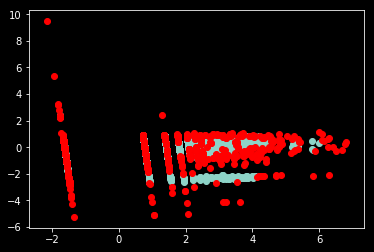

In [16]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_kddcup99
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# change plt style
plt.style.use("dark_background")

# load datasets
kdd_datasets = fetch_kddcup99(subset="smtp")
# dim reduction by PCA
pca = PCA(n_components=2)
X = pca.fit_transform(kdd_datasets.data)

# fit and predict by LOF
lof = LocalOutlierFactor().fit_predict(X)

# plot predict data
normal_predict = X[lof == 1]
anomal_predict = X[lof == -1]
plt.scatter(normal_predict[:, 0], normal_predict[:, 1])
plt.scatter(anomal_predict[:, 0], anomal_predict[:, 1], color="r")

plt.legend()
plt.show()

### ここまでの考察
ガウス分布を元に閾値を定める手法ではないため，グラフ左側の密度の小さい分布でも正常と検出されていることがわかる．  
手法がLOFであるため当然とも言える．

## 鍵情報を用いたテスト
### 方針
ON/OFFをひとつのデータセットとして取り扱うとしても，異なる分布で正常な検出ができると想定できる．  
ただし，効果の違いを見る必要があると思われる．

特徴量を下記に設定する．  
* イベント month
* イベント day
* イベント week
* イベント hour

### 実装

#### データ加工

In [73]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# const val
ISO_DATE_LEN = 24

# change plt style
plt.style.use("dark_background")

# load datasets
df = pd.read_csv("./key_info_20181102_anomaly.csv")
# convert str(ISO 8601 format) to datetime and convert timezone UTC to Asia/Tokyo
df["time"] = df["time"].str.ljust(ISO_DATE_LEN, "0")
df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(tz="UTC").dt.tz_convert(tz="Asia/Tokyo")

# make column
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["week"] = df["time"].dt.weekday
df["hour"] = df["time"].dt.hour
df = pd.concat([df, pd.get_dummies(df["state"])], axis=1) # get state's dummy

# to ndarray
X_on = df[df["state"].str.match("ON")][["month", "day", "week", "hour"]].values
y_on = df[df["state"].str.match("ON")][["is_anomal"]].values
X_off = df[df["state"].str.match("OFF")][["month", "day", "week", "hour"]].values
y_off = df[df["state"].str.match("OFF")][["is_anomal"]].values

<class 'pandas.core.frame.DataFrame'>
0      0
1      1
2      0
3      1
4      0
5      1
6      0
7      1
8      0
9      1
10     0
11     1
12     0
13     1
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     0
23     1
24     0
25     1
26     0
27     1
28     0
29     1
      ..
147    1
148    0
149    1
150    0
151    1
152    0
153    1
154    0
155    1
156    0
157    1
158    0
159    1
160    0
161    1
162    0
163    1
164    0
165    1
166    0
167    1
168    0
169    1
170    0
171    1
172    0
173    1
174    0
175    1
176    0
Name: OFF, Length: 177, dtype: uint8


#### LOFによる異常検知
まずは，ON/OFFを分割して効果を見る

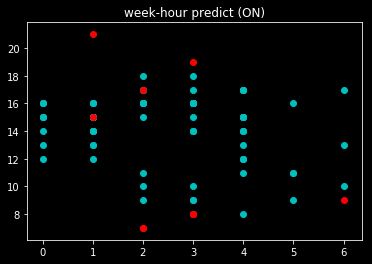

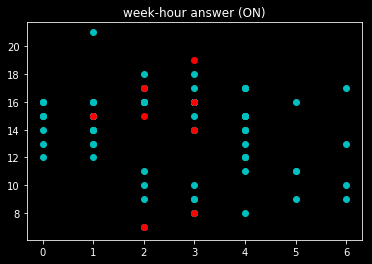

f1 score (ON): 0.35294117647058826


In [54]:
from sklearn.metrics import f1_score

# fit and predict by LOF
lof = LocalOutlierFactor().fit_predict(X_on)

# plot predict data
normal_predict = X_on[lof == 1]
anomal_predict = X_on[lof == -1]
plt.scatter(normal_predict[:, 2], normal_predict[:, 3], color="c")
plt.scatter(anomal_predict[:, 2], anomal_predict[:, 3], color="r")

plt.title("week-hour predict (ON)")
plt.legend()
plt.show()

# plot answer data
X_on_normal = X_on[y_on[:, 0] == False]
X_on_anomal = X_on[y_on[:, 0] == True]
plt.scatter(X_on_normal[:, 2], X_on_normal[:, 3], color="c")
plt.scatter(X_on_anomal[:, 2], X_on_anomal[:, 3], color="r")
plt.title("week-hour answer (ON)")
plt.legend()
plt.show()

# calc f1 score
y_true = y_on[:, 0] == True
y_pred = lof == -1
f1_value = f1_score(y_true, y_pred)
print("f1 score (ON): " + str(f1_value))

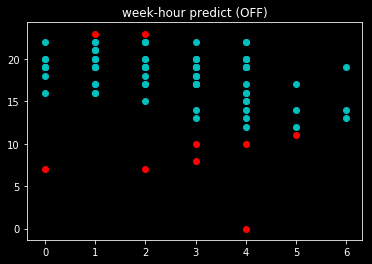

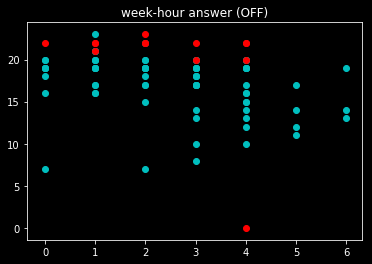

f1 score (OFF): 0.18181818181818185


In [55]:
from sklearn.metrics import f1_score

# fit and predict by LOF
lof = LocalOutlierFactor().fit_predict(X_off)

# plot predict data
normal_predict = X_off[lof == 1]
anomal_predict = X_off[lof == -1]
plt.scatter(normal_predict[:, 2], normal_predict[:, 3], color="c")
plt.scatter(anomal_predict[:, 2], anomal_predict[:, 3], color="r")

plt.title("week-hour predict (OFF)")
plt.legend()
plt.show()

# plot answer data
X_off_normal = X_off[y_off[:, 0] == False]
X_off_anomal = X_off[y_off[:, 0] == True]
plt.scatter(X_off_normal[:, 2], X_off_normal[:, 3], color="c")
plt.scatter(X_off_anomal[:, 2], X_off_anomal[:, 3], color="r")
plt.title("week-hour answer (OFF)")
plt.legend()
plt.show()

# calc f1 score
y_true = y_off[:, 0] == True
y_pred = lof == -1
f1_value = f1_score(y_true, y_pred)
print("f1 score (OFF): " + str(f1_value))

ON, OFFをあわせてテスト  
このとき，要素を1つ追加してON/OFFの情報を付与

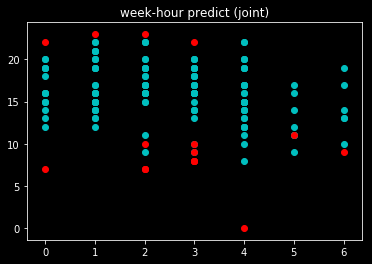

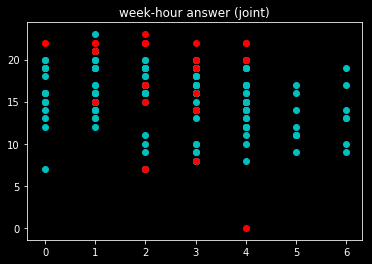

f1 score (joint): 0.30769230769230765


In [74]:
from sklearn.metrics import f1_score

# joint X datasets
X_joint = df[["month", "day", "week", "hour", "ON"]].values
y_joint = df[["is_anomal"]].values

# fit and predict by LOF
lof = LocalOutlierFactor().fit_predict(X_joint)

# plot predict data
normal_predict = X_joint[lof == 1]
anomal_predict = X_joint[lof == -1]
plt.scatter(normal_predict[:, 2], normal_predict[:, 3], color="c")
plt.scatter(anomal_predict[:, 2], anomal_predict[:, 3], color="r")

plt.title("week-hour predict (joint)")
plt.legend()
plt.show()

# plot answer data
X_joint_normal = X_joint[y_joint[:, 0] == False]
X_joint_anomal = X_joint[y_joint[:, 0] == True]
plt.scatter(X_joint_normal[:, 2], X_joint_normal[:, 3], color="c")
plt.scatter(X_joint_anomal[:, 2], X_joint_anomal[:, 3], color="r")
plt.title("week-hour answer (joint)")
plt.legend()
plt.show()

# calc f1 score
y_true = y_joint[:, 0] == True
y_pred = lof == -1
f1_value = f1_score(y_true, y_pred)
print("f1 score (joint): " + str(f1_value))

### ここまでの考察
ステータスがoffのときやたらF値が低い．  
なぜなのかを検証して見る必要がある．

### 異常検知した値の表示
それぞれで異常検知した時のデータを表示する．  
目視で問題がないか検討する．

In [91]:
# on predict
lof = LocalOutlierFactor().fit_predict(X_on)
anomal_on_df = pd.DataFrame(X_on[lof == -1], columns=["month", "day", "week", "hour"])
print("on")
print(anomal_on_df)

# off predict
lof = LocalOutlierFactor().fit_predict(X_off)
anomal_off_df = pd.DataFrame(X_off[lof == -1], columns=["month", "day", "week", "hour"])
print("off")
print(anomal_off_df)

# join predict
lof = LocalOutlierFactor().fit_predict(X_joint)
anomal_joint_df = pd.DataFrame(X_joint[lof == -1], columns=["month", "day", "week", "hour", "ON"])
print("joint")
print(anomal_joint_df[anomal_joint_df["ON"] == 1])
print(anomal_joint_df[anomal_joint_df["ON"] == 0])

# answer
print("answer")
print(df[df["is_anomal"] == 1][df["ON"] == 1][["month", "day", "week", "hour", "ON"]])
print(df[df["is_anomal"] == 1][df["ON"] == 0][["month", "day", "week", "hour", "ON"]])

on
   month  day  week  hour
0      5   29     1    15
1      8   22     2     7
2      8   22     2     7
3      8   23     3     8
4      8   30     3    19
5      9    2     6     9
6     10    9     1    21
7     10   31     2    17
8     11    1     3     8
off
   month  day  week  hour
0      8   20     0     7
1      8   22     2     7
2      8   23     3     8
3      8   31     4     0
4      9   14     4    10
5      9   15     5    11
6     10   30     1    23
7     10   31     2    23
8     11    1     3    10
joint
    month  day  week  hour  ON
1       8   22     2     7   1
3       8   22     2     7   1
4       8   23     3     8   1
6       8   23     3     9   1
8       9    2     6     9   1
9       9    5     2    10   1
10      9    6     3     8   1
11     10    6     5    11   1
15     11    1     3     8   1
    month  day  week  hour  ON
0       8   20     0     7   0
2       8   22     2     7   0
5       8   23     3     8   0
7       8   31     4     0   0
12

/Users/equanz/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/equanz/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### ここまでの考察
offのとき，正解データは，残業を異常としている傾向がある．  
また，予測値は早朝を主に捉えている傾向にある．

ここから，残業はデータとしては異常値でないという興味深い考察が得られる．  
本当に予測するならば，分類問題として教師あり学習するほうが良いと思われる．